# Preface

This kernel is a fork of [this](https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version) kernel made to work on Fast.AI and <br>
Uses Weighted BCE Loss as described in [this](https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution) kernel. <br>
Other than that nothing else has been changed. All improvemnts mentioned [here](https://www.kaggle.com/bminixhofer/simple-lstm-pytorch-version) could still apply.

In [14]:
import pandas as pd
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

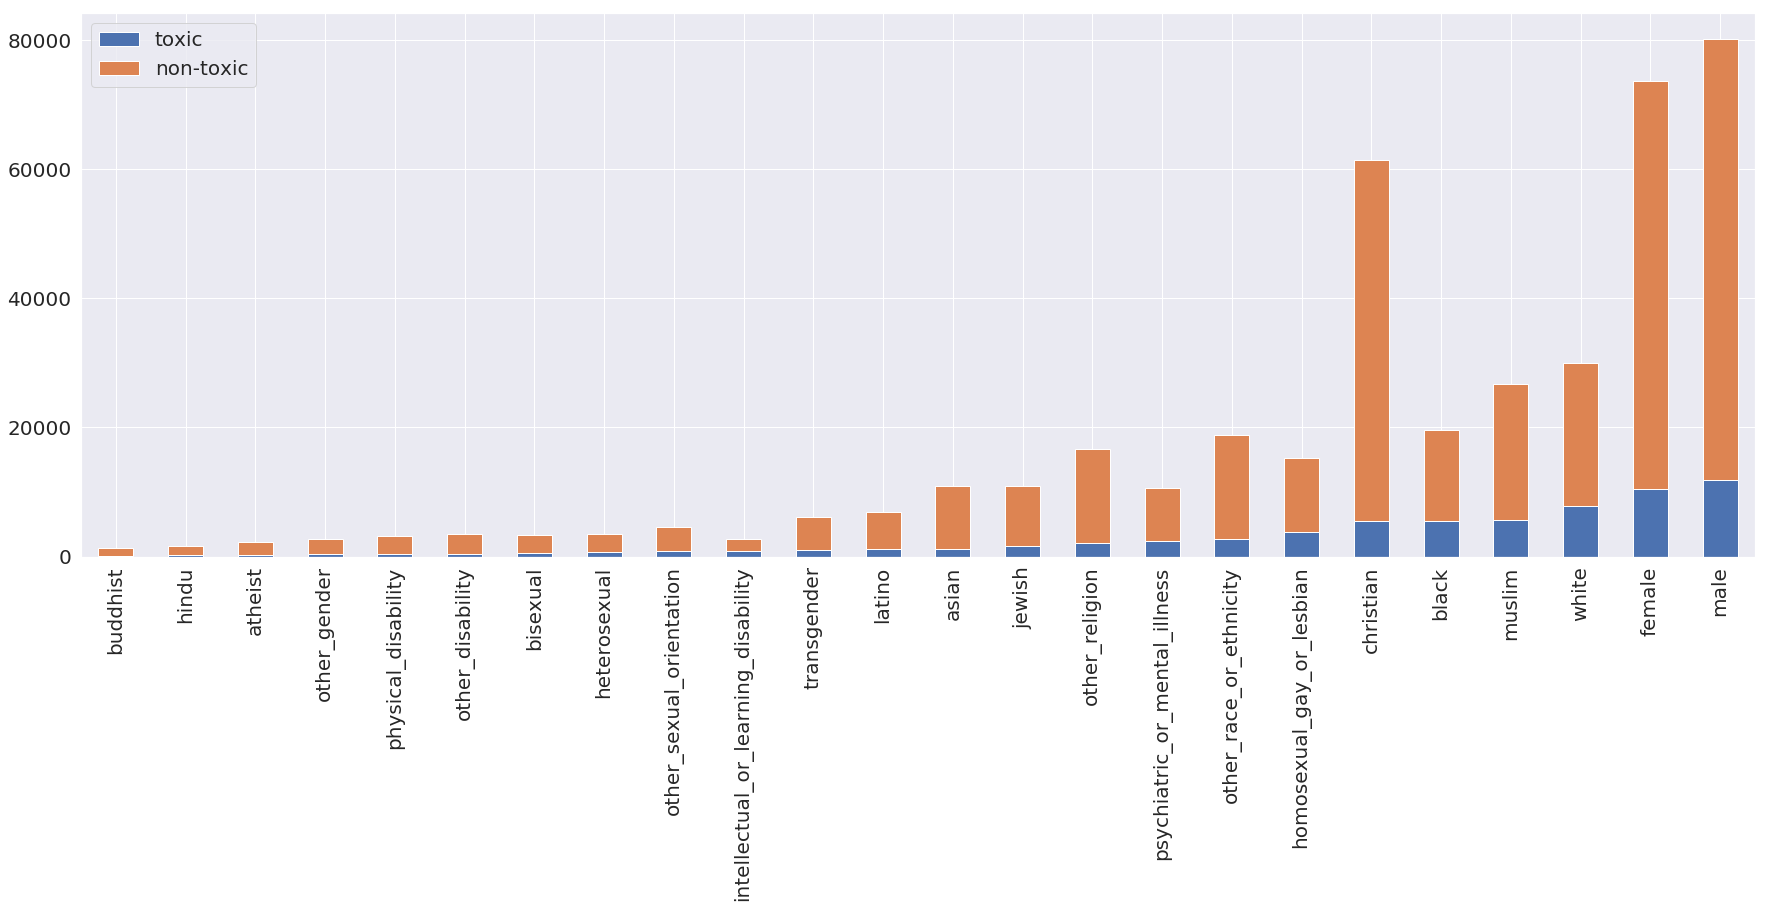

In [15]:
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']
# getting the dataframe with identities tagged
train_labeled_df = train.loc[:, ['target'] + identities ].dropna()
# lets define toxicity as a comment with a score being equal or .5
# in that case we divide it into two dataframe so we can count toxic vs non toxic comment per identity
toxic_df = train_labeled_df[train_labeled_df['target'] >= .5][identities]
non_toxic_df = train_labeled_df[train_labeled_df['target'] < .5][identities]
# at first, we just want to consider the identity tags in binary format. So if the tag is any value other than 0 we consider it as 1.
toxic_count = toxic_df.where(train_labeled_df == 0, other = 1).sum()
non_toxic_count = non_toxic_df.where(train_labeled_df == 0, other = 1).sum()
# now we can concat the two series together to get a toxic count vs non toxic count for each identity
toxic_vs_non_toxic = pd.concat([toxic_count, non_toxic_count], axis=1)
toxic_vs_non_toxic = toxic_vs_non_toxic.rename(index=str, columns={1: "non-toxic", 0: "toxic"})
# here we plot the stacked graph but we sort it by toxic comments to (perhaps) see something interesting
toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', stacked=True, figsize=(30,10), fontsize=20).legend(prop={'size': 20})

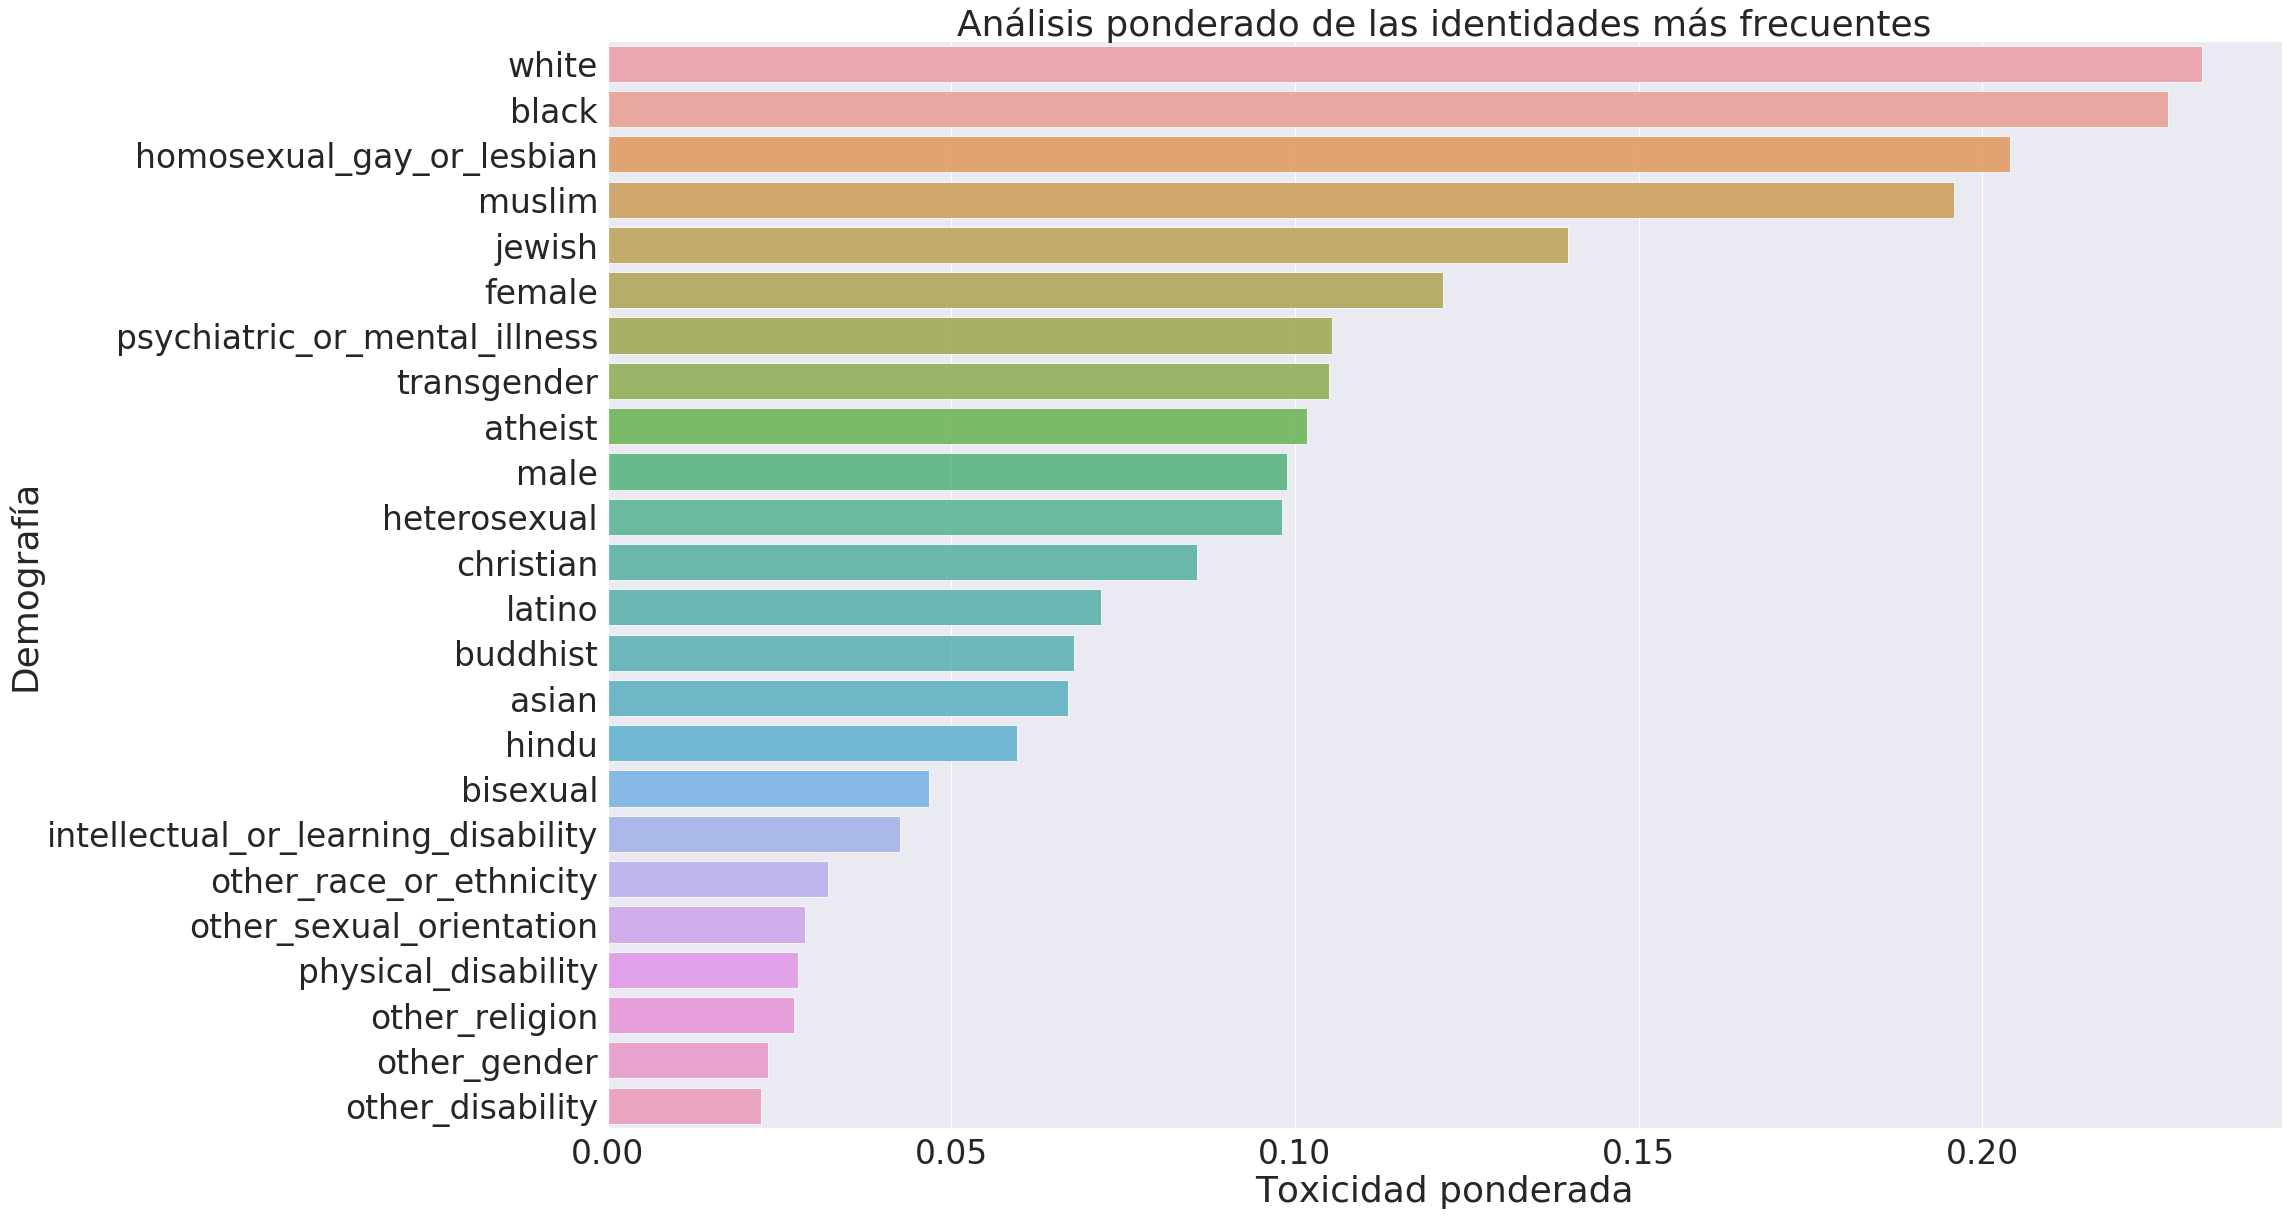

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# First we multiply each identity with the target
weighted_toxic = train_labeled_df.iloc[:, 1:].multiply(train_labeled_df.iloc[:, 0], axis="index").sum() 
# changing the value of identity to 1 or 0 only and get comment count per identity group
identity_label_count = train_labeled_df[identities].where(train_labeled_df == 0, other = 1).sum()
# then we divide the target weighted value by the number of time each identity appears
weighted_toxic = weighted_toxic / identity_label_count
weighted_toxic = weighted_toxic.sort_values(ascending=False)
# plot the data using seaborn like before
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = weighted_toxic.values , y = weighted_toxic.index, alpha=0.8)
plt.ylabel('Demografía')
plt.xlabel('Toxicidad ponderada')
plt.title('Análisis ponderado de las identidades más frecuentes')
plt.show()

# Imports & Utility functions

In [17]:
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.callbacks import *
from fastai.basic_data import DatasetType

In [18]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F

Using TensorFlow backend.


In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [19]:
#from gensim.models import KeyedVectors
CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

#CRAWL_embedding_index = KeyedVectors.load_word2vec_format(CRAWL_EMBEDDING_PATH, binary=False)
#GLOVE_embedding_index = KeyedVectors.load_word2vec_format(GLOVE_EMBEDDING_PATH, binary=False)


In [20]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))


In [21]:

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [22]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_model(learn,test,output_dim,lr=0.001,
                batch_size=512, n_epochs=4,
                enable_checkpoint_ensemble=True):
    
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('lr', lr * (0.6**(i)))) for i in range(n_epochs)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    for epoch in range(n_epochs):
        learn.fit(1)
        test_preds = np.zeros((len(test), output_dim))    
        for i, x_batch in enumerate(test_loader):
            X = x_batch[0].cuda()
            y_pred = sigmoid(learn.model(X).detach().cpu().numpy())
            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

        all_test_preds.append(test_preds)


    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

In [23]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [24]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    
    def clean_numbers(x):

        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
        return x

    def _get_mispell(mispell_dict):
        mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
        return mispell_dict, mispell_re

    mispell_dict = {'colour':'color',
                'centre':'center',
                'didnt':'did not',
                'doesnt':'does not',
                'isnt':'is not',
                'shouldnt':'should not',
                'favourite':'favorite',
                'travelling':'traveling',
                'counselling':'counseling',
                'theatre':'theater',
                'cancelled':'canceled',
                'labour':'labor',
                'organisation':'organization',
                'wwii':'world war 2',
                'citicise':'criticize',
                'instagram': 'social medium',
                'whatsapp': 'social medium',
                'snapchat': 'social medium'

                }
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace_typical_misspell(text):
        def replace(match):
            return mispellings[match.group(0)]
        return mispellings_re.sub(replace, text)
    
    contraction_mapping = {"Trump's": "Trump is","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
    
    def known_contractions(text):
        known = []
        for contract in contraction_mapping:
            if contract in text:
                known.append(contract)
        return known
    
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    data = data.astype(str).apply(lambda x: replace_typical_misspell(x))
    data = data.astype(str).apply(lambda x: clean_numbers(x))
    data = data.astype(str).apply(lambda x: known_contractions(x))
    return data

# Preprocessing

In [25]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

In [26]:
x_train = preprocess(train['comment_text'])
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Overall
weights = np.ones((len(x_train),)) / 4
# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
loss_weight = 1.0 / weights.mean()

In [ ]:
y_train = np.vstack([(train['target'].values>=0.5).astype(np.int),weights]).T

In [ ]:
max_features = None

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [ ]:
max_features = max_features or len(tokenizer.word_index) + 1
max_features

In [ ]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

In [ ]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

In [ ]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

In [ ]:
x_train_torch = torch.tensor(x_train, dtype=torch.long)
y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32)

In [ ]:
x_test_torch = torch.tensor(x_test, dtype=torch.long)

# Training

In [ ]:
batch_size = 512

train_dataset = data.TensorDataset(x_train_torch, y_train_torch)
valid_dataset = data.TensorDataset(x_train_torch[:batch_size], y_train_torch[:batch_size])
test_dataset = data.TensorDataset(x_test_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

databunch = DataBunch(train_dl=train_loader,valid_dl=valid_loader)

In [ ]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

In [ ]:
all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    learn = Learner(databunch,model,loss_func=custom_loss)
    test_preds = train_model(learn,test_dataset,output_dim=7)    
    all_test_preds.append(test_preds)

In [ ]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)